<a href="https://colab.research.google.com/github/inshra12/Protein-Sequence-Clustering/blob/main/Protein_Sequence_Clustering_using_ESM2_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Protein Sequence Clustering using ESM2 Embeddings

In [1]:
#import Libraries
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.6 MB/s eta 0:00:00


In [27]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer,AutoModel
from warnings import filterwarnings
filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
#Read Fasta File
record = list(SeqIO.parse("/content/proteinSequences.fasta", "fasta"))

In [4]:
print(record)

[SeqRecord(seq=Seq('MGNIKFLLLVFFLIVVVVNGCWEEERNALLELQTNIMSSNGELLVDWAGYNAAH...NVG'), id='sp|A0A3Q7HJG4|CURE1_SOLLC', name='sp|A0A3Q7HJG4|CURE1_SOLLC', description='sp|A0A3Q7HJG4|CURE1_SOLLC Cuscuta receptor 1 OS=Solanum lycopersicum OX=4081 GN=Solyc08g016270 PE=1 SV=1', dbxrefs=[]), SeqRecord(seq=Seq('MNGLFLFCVATTAALAYGSDAPCTNSGGVCQDDHLACHNGHYQSGLCTGGAHRR...NSK'), id='sp|B3A003|LYS3_CRAVI', name='sp|B3A003|LYS3_CRAVI', description='sp|B3A003|LYS3_CRAVI Lysozyme 3 OS=Crassostrea virginica OX=6565 GN=lysoz3 PE=1 SV=1', dbxrefs=[]), SeqRecord(seq=Seq('SLSDKDKTFVKAFWGKLKGKADDVGAEALARMFGAFPATKSYFAHWPDLSAGSG...KYR'), id='sp|B3EWR7|HBAC_OPHSE', name='sp|B3EWR7|HBAC_OPHSE', description='sp|B3EWR7|HBAC_OPHSE Hemoglobin cathodic subunit alpha OS=Ophisurus serpens OX=1234705 PE=1 SV=1', dbxrefs=[]), SeqRecord(seq=Seq('MLKLTLTILAAVLLVTPAFGKVYTRCSLAREMHTLGVPKNQLARWTCIAEHESA...DCF'), id='sp|C0HLB7|LYS2_LUCSE', name='sp|C0HLB7|LYS2_LUCSE', description='sp|C0HLB7|LYS2_LUCSE Lysozyme 2 OS=Lucilia serica

In [14]:
#Convert in to DataFrame
protein_family = []
for r in record:
  desc = r.description
  if "Hemoglobin" in desc:
    protein_family.append("Hemoglobin")
  elif "Lysozyme" in desc:
    protein_family.append("Lysozyme")
  elif "kinase" in desc:
    protein_family.append("Kinase")
  else:
    protein_family.append("Unknown")

In [15]:

data = pd.DataFrame({
     "id": [r.id for r in record],
     "sequence" : [str(r.seq) for r in record],
     "length" : [len(r.seq) for r in record],
     "family" : protein_family
})

In [18]:
print(data['family'].head())

0       Unknown
1      Lysozyme
2    Hemoglobin
3      Lysozyme
4      Lysozyme
Name: family, dtype: object


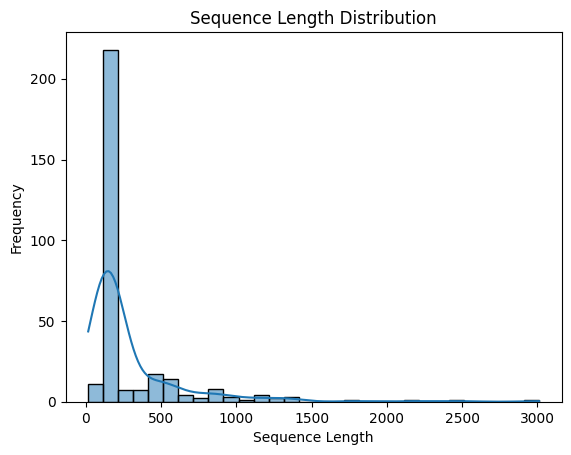

In [24]:
#Plot Sequence length distribution
sns.histplot(data['length'] , bins =30, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Sequence Length Distribution")
plt.show()


In [28]:
#ESM2 Embedding
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = model.to(device)
model = model.eval()

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/566 [00:00<?, ?it/s]

EsmModel LOAD REPORT from: facebook/esm2_t33_650M_UR50D
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
esm.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
pooler.dense.bias           | MISSING    | 
pooler.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [29]:
#esm2 Function
def emb_sequence(seq):
  inputs = tokenizer(seq, return_tensors="pt", truncation = True)
  inputs = {key: value.to(device) for key, value in inputs.items()} #move inputs to GPU

  with torch.no_grad(): #no need for traning just used it for prediciton
    outputs = model(**inputs)
  embedding = outputs.last_hidden_state.mean(dim=1) #average pooling
  return embedding.squeeze().cpu().numpy()



In [30]:
embeddings = []
for seq in data['sequence']:
 emb = emb_sequence(seq)
 embeddings.append(emb)

In [31]:
embeddings_matrix = np.vstack(embeddings) #convert into 2D matrix
print("Embedding matrix shape:", embeddings_matrix.shape)

Embedding matrix shape: (305, 1280)


In [32]:
#dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings_matrix)

tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(embeddings_matrix)



In [33]:
#kmeans Clusttering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings_matrix)

In [35]:
#Evaluation
from sklearn.metrics import confusion_matrix, classification_report
true_labels = data['family'].values
# Map cluster number to most frequent family in that cluster
cluster_to_family = {}
for cluster in np.unique(clusters):
    idx = np.where(clusters == cluster)[0]
    most_common_family = np.bincount([np.where(data['family'].unique() == true_labels[i])[0][0] for i in idx]).argmax()
    cluster_to_family[cluster] = data['family'].unique()[most_common_family]

pred_labels = np.array([cluster_to_family[c] for c in clusters])

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=data['family'].unique())
print("Confusion Matrix:\n", cm)

# Classification report
print("Classification Report:\n", classification_report(true_labels, pred_labels))

# Simple accuracy
accuracy = np.mean(pred_labels == true_labels)
print("K-means clustering accuracy:", accuracy)

Confusion Matrix:
 [[  0   8   1  31]
 [  0  84   0   8]
 [  0   0 103   0]
 [  0   7   6  57]]
Classification Report:
               precision    recall  f1-score   support

  Hemoglobin       0.94      1.00      0.97       103
      Kinase       0.59      0.81      0.69        70
    Lysozyme       0.85      0.91      0.88        92
     Unknown       0.00      0.00      0.00        40

    accuracy                           0.80       305
   macro avg       0.59      0.68      0.63       305
weighted avg       0.71      0.80      0.75       305

K-means clustering accuracy: 0.8


In [36]:
# Mask out 'Other'

mask = data['family'] != 'Other'
true_labels_simple = data['family'][mask].values
clusters_simple = clusters[mask]

# Map cluster number to most frequent family in that cluster

cluster_to_family = {}
for cluster in np.unique(clusters_simple):
    idx = np.where(clusters_simple == cluster)[0]
    # find most common family in this cluster
    most_common_family = np.bincount([np.where(np.unique(true_labels_simple) == true_labels_simple[i])[0][0] for i in idx]).argmax()
    cluster_to_family[cluster] = np.unique(true_labels_simple)[most_common_family]

# Predicted labels for masked data
pred_labels_simple = np.array([cluster_to_family[c] for c in clusters_simple])

# Confusion matrix and classification report

cm = confusion_matrix(true_labels_simple, pred_labels_simple, labels=np.unique(true_labels_simple))
print("Confusion Matrix (without 'Other'):\n", cm)

print("Classification Report (without 'Other'):\n", classification_report(true_labels_simple, pred_labels_simple))

# Simple accuracy
accuracy = np.mean(pred_labels_simple == true_labels_simple)
print("K-means clustering accuracy (without 'Other'):", accuracy)


Confusion Matrix (without 'Other'):
 [[103   0   0   0]
 [  6  57   7   0]
 [  0   8  84   0]
 [  1  31   8   0]]
Classification Report (without 'Other'):
               precision    recall  f1-score   support

  Hemoglobin       0.94      1.00      0.97       103
      Kinase       0.59      0.81      0.69        70
    Lysozyme       0.85      0.91      0.88        92
     Unknown       0.00      0.00      0.00        40

    accuracy                           0.80       305
   macro avg       0.59      0.68      0.63       305
weighted avg       0.71      0.80      0.75       305

K-means clustering accuracy (without 'Other'): 0.8


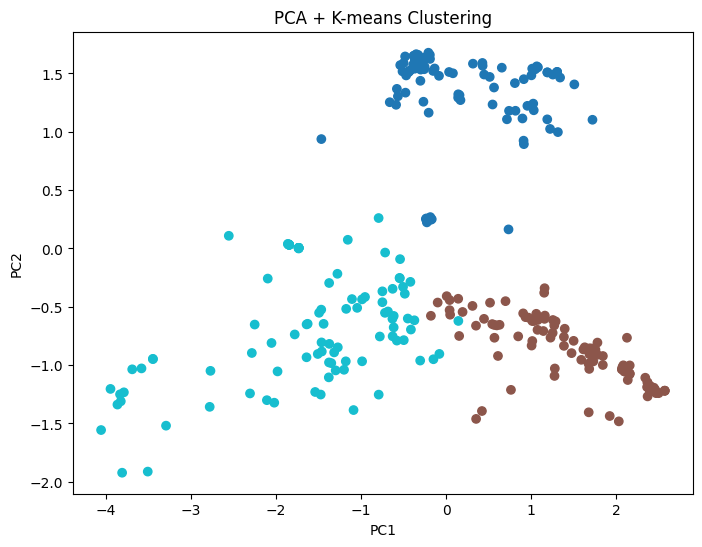

In [37]:
# PCA plot colored by K-means cluster
plt.figure(figsize=(8,6))
plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=clusters, cmap='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA + K-means Clustering")
plt.show()

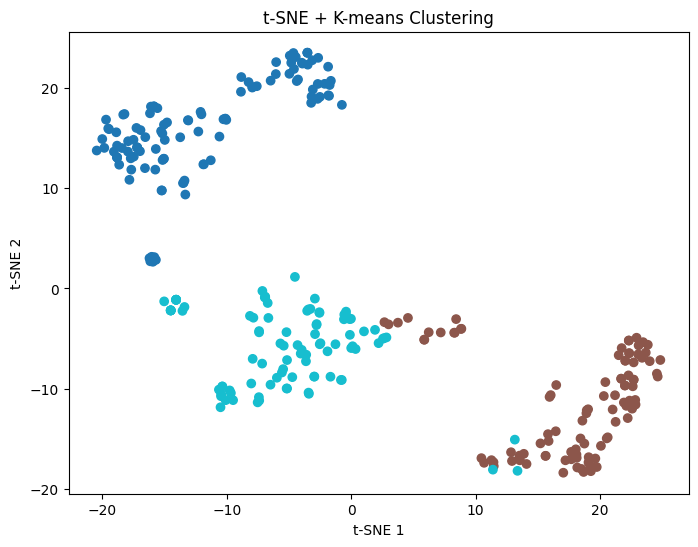

In [38]:

# t-SNE plot colored by K-means cluster
plt.figure(figsize=(8,6))
plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=clusters, cmap='tab10')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE + K-means Clustering")
plt.show()

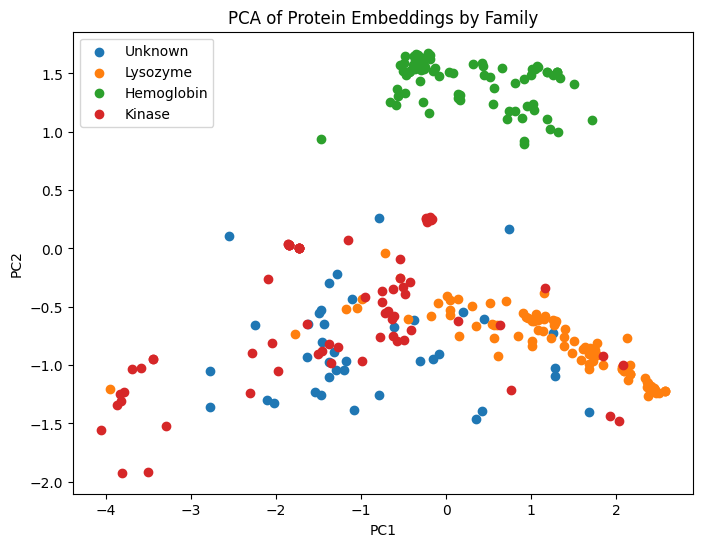

In [39]:
# PCA plot colored by true family
plt.figure(figsize=(8,6))
for fam in data['family'].unique():
    idx = data['family'] == fam
    plt.scatter(pca_embeddings[idx,0], pca_embeddings[idx,1], label=fam)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Protein Embeddings by Family")
plt.legend()
plt.show()